# WIDER FACE 데이터셋
## WIDER FACE 데이터셋
- 오늘 우리가 Face Detection 모델의 학습을 위해 다루게 될 데이터셋은 바로 WIDER FACE 데이터셋입니다. 빠른 인퍼런스 타임을 위해 사용할 YOLO, SSD 같은 single stage model을 학습시키는 것은 흔히 COCO 데이터셋 같은 것이 사용되겠지만, 오늘 우리가 추구하는 [먼 거리에 흩어져 있는 다수의 사람 얼굴을 빠르게 detect하는 모델]을 만들기 위해서는 그에 적합하게 '보다 넓은 공간에 있는 다수의 사람이 등장하는 이미지 데이터셋'이 필요하겠죠? 아래 그림에서 확인할 수 있듯, WIDER FACE 데이터셋은 그런 용도로 활용하기에 적절해 보입니다.
- WIDER FACE 데이터셋 홈페이지에 접속하여 아래 4개의 zip파일을 다운받아 ~/aiffel/face_detector/widerface에 저장합니다. 다운받아야 할 WIDER_xxx.zip 파일들은 구글드라이브에 올라가 있습니다. 아래 코드를 실행하면 다운로드가 자동으로 진행됩니다.
- WIDER Face Dataset의 전체 이미지 개수와 얼굴 개수는 각각 얼마인가요?
    - 32,203개의 이미지, 393,703개의 얼굴 데이터가 존재함
- WIDER Face Dataset에서 train/validataion/test 의 구성비율은 각각 몇%씩인가요?
    - train/validataion/test 의 구성비율이 각각 40%/10%/50%로 구성되어 있습니다.


In [106]:
import os

# datasets = [
#    ('WIDER_train.zip', '0B6eKvaijfFUDQUUwd21EckhUbWs'),
#    ('WIDER_val.zip', '0B6eKvaijfFUDd3dIRmpvSk8tLUk'),
#    ('WIDER_test.zip', '0B6eKvaijfFUDbW4tdGpaYjgzZkU'),
# ]

# os.system('cd ~/aiffel/face_detector && mkdir widerface && cd widerface')

# for FILENAME, FILEID in datasets:
#    command = f"wget --load-cookies /tmp/cookies.txt \"https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILEID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\\1\\n/p')&id={FILEID}\" -O widerface/{FILENAME} && rm -rf /tmp/cookies.txt"
#    os.system(command)

# os.system('wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip -O widerface/wider_face_split.zip')

# 데이터셋 전처리(1) 분석
## WIDER FACE Bounding Box
- 10개의 숫자로 이루어진 [face bounding box 좌표 등 상세정보]는 다음과 같은 의미를 가집니다.
    - x0, y0, w, h, blur, expression, illumination, invalid, occlusion, pose
- bounding box가 관련해서 가장 중요한 4개의 숫자는 왼쪽의 4개(좌상 꼭지점 X좌표, Y좌표, 너비, 높이)입니다.
- 이 파일을 분석하는 코드는 아래와 같습니다.

In [107]:
def get_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

In [108]:
def parse_widerface(config_path):
    boxes_per_img = []
    with open(config_path) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            num_of_obj = int(fp.readline())
            boxes = []
            for i in range(num_of_obj):
                obj_box = fp.readline().split(' ')
                x0, y0, w, h = get_box(obj_box)
                if w == 0:
                    # remove boxes with no width
                    continue
                if h == 0:
                    # remove boxes with no height
                    continue
                # Because our network is outputting 7x7 grid then it's not worth processing images with more than
                # 5 faces because it's highly probable they are close to each other.
                # You could remove this filter if you decide to switch to larger grid (like 14x14)
                # Don't worry about number of train data because even with this filter we have around 16k samples
                boxes.append([x0, y0, w, h])
            if num_of_obj == 0:
                obj_box = fp.readline().split(' ')
                x0, y0, w, h = get_box(obj_box)
                boxes.append([x0, y0, w, h])
            boxes_per_img.append((line.strip(), boxes))
            line = fp.readline()
            cnt += 1

    return boxes_per_img

- 위 메소드는 이미지별 bounding box 정보를 wider_face_train_bbx_gt.txt에서 파싱해서 리스트로 추출하는 것입니다. boudbing box 정보는 [x, y, w, h] 형태로 저장되어 있는데, 아래 코드를 통해 x_min, y_min, x_max, y_max 형태의 꼭지점 좌표 정보로 변환하여 출력해 보겠습니다.

In [109]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        logging.info('{}: Invalid JPEG data or crop window'.format(image_file))
        return 1, image_string, None

In [110]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

In [111]:
import os
import tensorflow as tf
dataset_path = os.getenv('HOME')+'/aiffel/face_detector/widerface'
anno_txt = 'wider_face_train_bbx_gt.txt'
file_path = 'WIDER_train'
for i, info in enumerate(parse_widerface(os.path.join(dataset_path, 'wider_face_split', anno_txt))):
    print('--------------------')
    image_file = os.path.join(dataset_path, file_path, 'images', info[0])
    error, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/home/aiffel0042/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/home/aiffel0042/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/home/aiffel0042/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 

- 어떤가요? 이미지별로 boxes 리스트에 담긴 bounding box 정보가 확인되시나요?
이제 이 정보를 활용하여 텐서플로우 데이터셋을 생성해 봅시다.

# 데이터셋 전처리(2) tf_example 생성
## tfrecord 만들기
- 오늘 우리가 다루게 될 대용량 데이터셋의 처리속도 향상을 위해서 전처리 작업을 통해 tfrecord 데이터셋으로 변환할 필요가 있습니다. 1개 데이터의 단위를 이루는 tf.train.Example 인스턴스를 생성하는 메소드는 아래와 같습니다.

In [112]:
def make_example(image_string, image_info_list):

    for info in image_info_list:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]

    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    return example

- 이제 전처리를 위해 필요한 메소드들이 어느정도 갖추어졌습니다. 데이터셋의 이미지파일, 그리고 bounding box를 파싱한 정보를 모아 위의 make_example 메소드를 통해 만든 example을 serialize하여 바이너리 파일로 생성하게 됩니다.

In [113]:
import logging
import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
rootPath = os.getenv('HOME')+'/aiffel/face_detector'
dataset_path = 'widerface'

if not os.path.isdir(dataset_path):
    logging.info('Please define valid dataset path.')
else:
    logging.info('Loading {}'.format(dataset_path))

logging.info('Reading configuration...')

for split in ['train', 'val']:
    output_file = rootPath + '/dataset/train_mask.tfrecord' if split == 'train' else rootPath + '/dataset/val_mask.tfrecord'

    with tf.io.TFRecordWriter(output_file) as writer:

        counter = 0
        skipped = 0
        anno_txt = 'wider_face_train_bbx_gt.txt' if split == 'train' else 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_train' if split == 'train' else 'WIDER_val'
        for info in tqdm.tqdm(parse_widerface(os.path.join(rootPath, dataset_path, 'wider_face_split', anno_txt))):
            image_file = os.path.join(rootPath, dataset_path, file_path, 'images', info[0])

            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])

                writer.write(tf_example.SerializeToString())
                counter += 1

            else:
                skipped += 1
                logging.info('Skipped {:d} of {:d} images.'.format(skipped, counter))

    logging.info('Wrote {} images to {}'.format(counter, output_file))

100%|██████████| 3226/3226 [00:07<00:00, 415.95it/s]


- 이전 스텝에서 여기까지의 전처리 과정을 tf_dataset_preprocess.py 에 정리해 두었습니다. 아래와 같이 위의 과정을 실행할 수 있습니다.
- $ python tf_dataset_preprocess.py

# 모델 구현(1) priors box
## SSD의 prior box
- SSD 모델의 가장 중요한 특징 중 하나는 prior box(또는 anchor box)를 필요로 한다는 점입니다. 
- prior box란, object가 존재할 만한 다양한 크기의 box의 좌표 및 클래스 정보를 일정 개수만큼 미리 고정해 둔 것입니다. 
- ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 이상(0.5) 겹치는 prior box를 선택하는 방식이 RCNN 계열의 sliding window 방식보다 훨씬 속도가 빠르면서도 그와 유사한 정도의 정확도를 얻을 수 있다는 장점이 있습니다.
- 이번 프로젝트에서 활용할 config 정보를 모아 아래와 같은 dict 구조로 정리하였습니다.



In [149]:
cfg = {
    # general setting
    "batch_size": 32,
    "input_size": (240, 320),  # (h,w)

    # training dataset
    "dataset_path": 'dataset/train_mask.tfrecord',  # 'dataset/trainval_mask.tfrecord'
    "val_path": 'dataset/val_mask.tfrecord',  #
    "dataset_len": 12880,  # train 6115 , trainval 7954, number of training samples
    "val_len": 3226,
    "using_crop": True,
    "using_bin": True,
    "using_flip": True,
    "using_distort": True,
    "using_normalizing": True,
    "labels_list": ['background', 'face'],  # xml annotation

    # anchor setting
    "min_sizes":[[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]],
    "steps": [8, 16, 32, 64],
    "match_thresh": 0.45,
    "variances": [0.1, 0.2],
    "clip": False,

    # network
    "base_channel": 16,

    # training setting
    "resume": False,  # if False,training from scratch
    "epoch": 200,
    "init_lr": 1e-2,
    "lr_decay_epoch": [50, 70],
    "lr_rate": 0.1,
    "warmup_epoch": 5,
    "min_lr": 1e-4,

    "weights_decay": 5e-4,
    "momentum": 0.9,
    "save_freq": 10, #frequency of save model weights

    # inference
    "score_threshold": 0.6,
    "nms_threshold": 0.4,
    "max_number_keep": 200
}

cfg

{'batch_size': 32,
 'input_size': (240, 320),
 'dataset_path': 'dataset/train_mask.tfrecord',
 'val_path': 'dataset/val_mask.tfrecord',
 'dataset_len': 12880,
 'val_len': 3226,
 'using_crop': True,
 'using_bin': True,
 'using_flip': True,
 'using_distort': True,
 'using_normalizing': True,
 'labels_list': ['background', 'face'],
 'min_sizes': [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]],
 'steps': [8, 16, 32, 64],
 'match_thresh': 0.45,
 'variances': [0.1, 0.2],
 'clip': False,
 'base_channel': 16,
 'resume': False,
 'epoch': 200,
 'init_lr': 0.01,
 'lr_decay_epoch': [50, 70],
 'lr_rate': 0.1,
 'warmup_epoch': 5,
 'min_lr': 0.0001,
 'weights_decay': 0.0005,
 'momentum': 0.9,
 'save_freq': 10,
 'score_threshold': 0.6,
 'nms_threshold': 0.4,
 'max_number_keep': 200}

- config 중 prior(anchor) box 생성과 관련된 것들은 다음과 같습니다.

In [115]:
image_sizes = cfg['input_size']
min_sizes = cfg["min_sizes"]
steps = cfg["steps"]
clip = cfg["clip"]

if isinstance(image_sizes, int):
    image_sizes = (image_sizes, image_sizes)
elif isinstance(image_sizes, tuple):
    image_sizes = image_sizes
else:
    raise Exception('Type error of input image size format,tuple or int. ')

print(image_sizes)

(240, 320)


- 위 그림에서 보는 것처럼, prior box를 생성하기 위해서는 먼저 기준이 되는 feature map을 먼저 생성합니다. 그림에서는 8X8, 4X4의 예가 나오지만, 우리의 프로젝트에서는 아래와 같이 4가지 유형의 feature map을 생성하게 됩니다.

In [116]:
import math
import numpy as np
from itertools import product

for m in range(4):
    if (steps[m] != pow(2, (m + 3))):
        print("steps must be [8,16,32,64]")
        sys.exit()

assert len(min_sizes) == len(steps), "anchors number didn't match the feature map layer."

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps]

feature_maps

[[30, 40], [15, 20], [8, 10], [4, 5]]

- 이제 feature map별로 순회를 하면서 prior box 를 생성해 보겠습니다.

In [117]:
anchors = []
num_box_fm_cell=[]
for k, f in enumerate(feature_maps):
    num_box_fm_cell.append(len(min_sizes[k]))
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            if isinstance(min_size, int):
                min_size = (min_size, min_size)
            elif isinstance(min_size, tuple):
                min_size=min_size
            else:
                raise Exception('Type error of min_sizes elements format,tuple or int. ')
            s_kx = min_size[1] / image_sizes[1]
            s_ky = min_size[0] / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            anchors += [cx, cy, s_kx, s_ky]

len(anchors)

17680

In [118]:
import numpy as np
priors = np.asarray(anchors).reshape([-1, 4])
priors.shape

(4420, 4)

In [119]:
priors

array([[0.0125    , 0.01666667, 0.03125   , 0.04166667],
       [0.0125    , 0.01666667, 0.05      , 0.06666667],
       [0.0125    , 0.01666667, 0.075     , 0.1       ],
       ...,
       [0.9       , 0.93333333, 0.4       , 0.53333333],
       [0.9       , 0.93333333, 0.6       , 0.8       ],
       [0.9       , 0.93333333, 0.8       , 1.06666667]])

- 이번 스텝에 소개한 prior_box 생성 과정을 make_prior_box.py에 정리해 두었습니다. 아래와 같이 위의 과정을 실행할 수 있습니다.
- $ cd ~/aiffel/face_detector && python make_prior_box.py
- 아래는 이번 스텝에서 prior box를 생성하는 최종 메소드인 prior_box() 입니다.

In [120]:
def prior_box(cfg,image_sizes=None):
    """prior box"""
    if image_sizes is None:
        image_sizes = cfg['input_size']
    min_sizes=cfg["min_sizes"]
    steps=cfg["steps"]
    clip=cfg["clip"]

    if isinstance(image_sizes, int):
        image_sizes = (image_sizes, image_sizes)
    elif isinstance(image_sizes, tuple):
        image_sizes = image_sizes
    else:
        raise Exception('Type error of input image size format,tuple or int. ')

    for m in range(4):
        if (steps[m] != pow(2, (m + 3))):
            print("steps must be [8,16,32,64]")
            sys.exit()

    assert len(min_sizes) == len(steps), "anchors number didn't match the feature map layer."

    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps]

    anchors = []
    num_box_fm_cell=[]
    for k, f in enumerate(feature_maps):
        num_box_fm_cell.append(len(min_sizes[k]))
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                if isinstance(min_size, int):
                    min_size = (min_size, min_size)
                elif isinstance(min_size, tuple):
                    min_size=min_size
                else:
                    raise Exception('Type error of min_sizes elements format,tuple or int. ')
                s_kx = min_size[1] / image_sizes[1]
                s_ky = min_size[0] / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                anchors += [cx, cy, s_kx, s_ky]

    output = np.asarray(anchors).reshape([-1, 4])

    if clip:
        output = np.clip(output, 0, 1)
    return output,num_box_fm_cell

# 모델 구현(2) SSD
## SSD model 빌드하기
- 그럼 본격적으로 SSD 모델을 생성해 보겠습니다.
- 우선은 SSD 모델 내부에서 사용하는 레이어들을 아래와 같이 생성합니다.

In [121]:
import tensorflow as tf

def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1), use_bn=True, padding=None, block_id=None):
    """Adds an initial convolution layer (with batch normalization and relu).
    # Returns
        Output tensor of block.
    """
    if block_id is None:
        block_id = (tf.keras.backend.get_uid())

    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False if use_bn else True,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False if use_bn else True,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    if use_bn:
        x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

In [122]:
def _depthwise_conv_block(inputs, pointwise_conv_filters,
                          depth_multiplier=1, strides=(1, 1), use_bn=True, block_id=None):
    """Adds a depthwise convolution block.
        # Returns
        Output tensor of block.
    """
    if block_id is None:
        block_id = (tf.keras.backend.get_uid())

    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)

    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        depth_multiplier=depth_multiplier,
                                        strides=strides,
                                        use_bias=False if use_bn else True,
                                        name='conv_dw_%d' % block_id)(x)
    if use_bn:
        x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)

    x = tf.keras.layers.Conv2D(pointwise_conv_filters, (1, 1),
                               padding='same',
                               use_bias=False if use_bn else True,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    if use_bn:
        x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

In [123]:
def _branch_block(input, filters):

    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(input)

    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])

    return tf.keras.layers.ReLU()(x)

In [124]:
def _create_head_block(inputs, filters, strides=(1, 1), block_id=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(inputs)
    return x

In [125]:
def _compute_heads(x, idx, num_class, num_cell):
    """ Compute outputs of classification and regression heads
    Args:
        x: the input feature map
        idx: index of the head layer
    Returns:
        conf: output of the idx-th classification head
        loc: output of the idx-th regression head
    """
    conf = _create_head_block(inputs=x, filters=num_cell[idx] * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs=x, filters=num_cell[idx] * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)

    return conf, loc

- 레이어들이 준비되었습니다. 이제 본격적으로 SSD model을 생성해 보겠습니다.

In [126]:
def SsdModel(cfg, num_cell, training=False, name='ssd_model'):
    image_sizes = cfg['input_size']   if training else None
    if isinstance(image_sizes, int):
        image_sizes = (image_sizes, image_sizes)
    elif isinstance(image_sizes, tuple):
        image_sizes = image_sizes
    elif image_sizes == None:
        image_sizes = (None, None)
    else:
        raise Exception('Type error of input image size format,tuple or int. ')

    base_channel = cfg["base_channel"]
    num_class = len(cfg['labels_list'])

    x = inputs = tf.keras.layers.Input(shape=[image_sizes[0], image_sizes[1], 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))  # 120*160*16
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))  # 60*80
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))  # 30*40
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))  # 15*20
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))  # 8*10
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))  # 4*5
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    head_idx = 0
    assert len(extra_layers) == len(num_cell)
    for layer in extra_layers:
        conf, loc = _compute_heads(layer, head_idx, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

        head_idx += 1

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])


    model = tf.keras.Model(inputs=inputs, outputs=predictions, name=name)
    return model

In [127]:
import os

model = SsdModel(cfg, num_cell=[3, 2, 2, 3], training=False)
print(len(model.layers))
model.summary()

101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_pad_29 (ZeroPadding2D)     (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv_29 (Conv2D)                (None, None, None, 1 432         conv_pad_29[0][0]                
__________________________________________________________________________________________________
conv_bn_29 (BatchNormalization) (None, None, None, 1 64          conv_29[0][0]                    
______________________________________________________________________________________

- 이번 스텝에 소개한 SSD model 생성 과정을 tf_build_ssd_model.py에 정리해 두었습니다. 아래와 같이 위의 과정을 실행할 수 있습니다.

- $ cd ~/aiffel/face_detector && python tf_build_ssd_model.py

# 18-6. 모델 학습(1) Augmentation, Prior 적용
## augmentation
- 모델까지 구성완료하였습니다. 그러나 본격적으로 train을 진행하기 전에 아직 몇가지가 더 남아있습니다.

- 이전 스텝에서 구성한 tfrecordset 형태의 데이터셋은 아직 Data augmentation이 적용되지 않았습니다. Object detection에서 사용하는 다양한 augmentation 기법을 적용해 주면 좀더 성능향상을 기대할 수도 있을 것입니다.

- 아래는 augmentation을 위해 tf.data.TFRecordDataset.map() 내에서 호출할 메소드들입니다.

    - _crop
    - _pad_to_square
    - _resize
    - _flip
    - _distort

In [128]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        """
        return iof of a and b, numpy version for data augenmentation
        """
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)


        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

In [129]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)

    return img

In [130]:
def _resize(img, labels, img_dim):
    ''' # resize and boxes coordinate to percent'''
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)
    if isinstance(img_dim, int):
        img_dim = (img_dim, img_dim)
    elif isinstance(img_dim,tuple):
        img_dim = img_dim
    else:
        raise Exception('Type error of input image size format,tuple or int. ')

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [img_dim[0], img_dim[1]], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

In [131]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

In [132]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

## Prior box 적용
- SSD 모델의 특이점 중 하나가 prior box를 사용한다는 점을 이미 앞에서 설명하였습니다. prior box 정보는 데이터셋에 반영되어야 합니다. 아래 메소드들은 prior box와 bounding box 사이의 IoU, 다른 말로 jaccard index를 측정하기 위한 것입니다. 이후 이 메소드를 활용해 어떻게 데이터셋을 추가로 가공하는지 살펴봅시다.

- (참고) 자카드 거리, 자카드 지수 https://rfriend.tistory.com/318



In [133]:
def _intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2]:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

In [134]:
def _jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

- jaccard index를 계산하는 메소드가 준비되었습니다. 아래 encode_tf는 이를 이용해서 tfrecord 데이터셋의 라벨을 가공하는 메소드입니다. 내용을 정리하면 다음과 같습니다.

    - jaccard 메소드를 이용해 label의 ground truth bbox와 가장 overlap 비율이 높은 matched prior를 구한다.
    - _encode_bbox 메소드를 통해 bbox의 scale을 동일하게 보정한다.
    - 전체 prior box에 대해 일정 threshold 이상 overlap되는 ground truth bounding box 존재 여부(positive/negative)를 concat하여 새로운 label로 업데이트한다.

In [135]:
def _encode_bbox(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth
    boxes we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of prior boxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """
    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - priors[:, :2]

    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])

    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]

    # return target for smooth_l1_loss
    return tf.concat([g_cxcy, g_wh], 1)  # [num_priors,4]

In [136]:
def encode_tf(labels, priors, match_thresh, variances=None):
    """tensorflow encoding"""
    if variances is None:
        variances = [0.1, 0.2]

    priors = tf.cast(priors, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]

    # jaccard index
    overlaps = _jaccard(bbox, priors)
    best_prior_overlap = tf.reduce_max(overlaps, 1)
    best_prior_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_prior_idx, 1),
        tf.ones_like(best_prior_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_prior_idx, 1),
        tf.range(tf.size(best_prior_idx), dtype=tf.int32))

    # Scale Ground-Truth Boxes
    matches_bbox = tf.gather(bbox, best_truth_idx)  # [num_priors, 4]
    loc_t = _encode_bbox(matches_bbox, priors, variances)
    conf_t = tf.gather(conf, best_truth_idx)  # [num_priors]
    conf_t = tf.where(tf.less(best_truth_overlap, match_thresh), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

## load_dataset
- 위에서 구현한 두가지 메소드를 이전 스텝에서 생성한 tfrecord 데이터셋에 적용하여 SSD 학습을 위한 데이터셋을 생성하는 최종 메소드인 load_dataset 을 구현합니다.

    - _transform_data : aumemtation과 prior box label을 적용하여 기존의 dataset을 변환하는 메소드
    - _parse_tfrecord : tfrecord 에 _transform_data를 적용하는 함수 클로저 생성
    - load_tfrecord_dataset : tf.data.TFRecordDataset.map()에 _parse_tfrecord을 적용하는 실제 데이터셋 변환 메인 메소드
    - load_dataset : load_tfrecord_dataset을 통해 train, validation 데이터셋을 생성하는 최종 메소드

In [137]:
def _transform_data(img_dim, using_crop,using_flip, using_distort, using_encoding,using_normalizing, priors,
                    match_thresh,  variances):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if using_crop:
        # randomly crop
            img, labels = _crop(img, labels)

            # padding to square
            img = _pad_to_square(img)

        # resize and boxes coordinate to percent
        img, labels = _resize(img, labels, img_dim)

        # randomly left-right flip
        if using_flip:
            img, labels = _flip(img, labels)

        # distort
        if using_distort:
            img = _distort(img)

        # encode labels to feature targets
        if using_encoding:
            labels = encode_tf(labels=labels, priors=priors, match_thresh=match_thresh, variances=variances)
        if using_normalizing:
            img=(img/255.0-0.5)/1.0

        return img, labels
    return transform_data

In [138]:
def _parse_tfrecord(img_dim,using_crop, using_flip, using_distort,
                    using_encoding, using_normalizing,priors, match_thresh,  variances):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(
            img_dim, using_crop,using_flip, using_distort, using_encoding, using_normalizing,priors,
            match_thresh,  variances)(img, labels)

        return img, labels
    return parse_tfrecord

In [139]:
def load_tfrecord_dataset(tfrecord_name, batch_size, img_dim,
                          using_crop=True,using_flip=True, using_distort=True,
                          using_encoding=True, using_normalizing=True,
                          priors=None, match_thresh=0.45,variances=None,
                          shuffle=True, repeat=True,buffer_size=10240):

    if variances is None:
        variances = [0.1, 0.2]

    """load dataset from tfrecord"""
    if not using_encoding:
        assert batch_size == 1
    else:
        assert priors is not None

    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if repeat:
        raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)


    dataset = raw_dataset.map(
        _parse_tfrecord(img_dim, using_crop, using_flip, using_distort,
                        using_encoding, using_normalizing,priors, match_thresh,  variances),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [140]:
def load_dataset(cfg, priors, shuffle=True, buffer_size=10240,train=True):
    """load dataset"""
    global dataset
    if train:
        logging.info("load train dataset from {}".format(cfg['dataset_path']))
        dataset = load_tfrecord_dataset(
            tfrecord_name=os.path.join(rootPath, cfg['dataset_path']),
            batch_size=cfg['batch_size'],
            img_dim=cfg['input_size'],
            using_crop=cfg['using_crop'],
            using_flip=cfg['using_flip'],
            using_distort=cfg['using_distort'],
            using_encoding=True,
            using_normalizing=cfg['using_normalizing'],
            priors=priors,
            match_thresh=cfg['match_thresh'],
            variances=cfg['variances'],
            shuffle=shuffle,
            repeat=True,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=os.path.join(rootPath, cfg['val_path']),
            batch_size=cfg['batch_size'],
            img_dim=cfg['input_size'],
            using_crop=False,
            using_flip=False,
            using_distort=False,
            using_encoding=True,
            using_normalizing=True,
            priors=priors,
            match_thresh=cfg['match_thresh'],
            variances=cfg['variances'],
            shuffle=shuffle,
            repeat=False,
            buffer_size=buffer_size)
        logging.info("load validation dataset from {}".format(cfg['val_path']))

    return dataset

- 이번 스텝에 소개한 load_dataset 메소드 구현체를 tf_dataloader.py에 정리해 두었습니다.

# 모델 학습(2) Train
## Learning rate scheduler
- 본격적으로 train에 들어가기 전에 2가지 더 준비해야 할 게 있습니다. 
- 그중 하나는 Learning rate scheduler 입니다. 
- 이번에는 구간별로 learning rate가 일정하게 유지하면서 감소하는 PiecewiseConstantDecay를 상속받아, 초기시점에 WarmUp부분을 추가한 PiecewiseConstantWarmUpDecay를 활용하겠습니다.

In [141]:
class PiecewiseConstantWarmUpDecay(
        tf.keras.optimizers.schedules.LearningRateSchedule):
    """A LearningRateSchedule wiht warm up schedule.
    Modified from tf.keras.optimizers.schedules.PiecewiseConstantDecay"""

    def __init__(self, boundaries, values, warmup_steps, min_lr,
                 name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                # Need to bind v here; can do this with lambda v=v: ...
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            # The default isn't needed here because our conditions are mutually
            # exclusive and exhaustive, but tf.case requires it.
            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

    def get_config(self):
        return {
                "boundaries": self.boundaries,
                "values": self.values,
                "warmup_steps": self.warmup_steps,
                "min_lr": self.min_lr,
                "name": self.name
        }

In [142]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    """Multi-steps warm up learning rate scheduler."""
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

## Hard negative mining
- Object Detection 모델 학습시 자주 사용되는 Hard negative mining이라는 기법이 있습니다. 학습과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다는 장점이 있습니다.

- 실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영할 수 있습니다.

- 아래 구현된 hard_negative_mining 메소드와, 이 메소드를 통해 얻은 샘플을 통해 얻은 localization loss를 기존의 classification loss에 추가로 반영하는 MultiBoxLoss 계산 메소드를 확인해 주세요.

In [143]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    """ Hard negative mining algorithm
        to pick up negative examples for back-propagation
        base on classification loss values
    Args:
        loss: list of classification losses of all default boxes (B, num_default)
        class_truth: classification targets (B, num_default)
        neg_ratio: negative / positive ratio
    Returns:
        class_loss: classification loss
        loc_loss: regression loss
    """
    # loss: B x N
    # class_truth: B x N
    pos_idx = class_truth > 0
    num_pos = tf.reduce_sum(tf.dtypes.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

In [144]:
def MultiBoxLoss(num_class=3, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        """ Compute losses for SSD
               regression loss: smooth L1
               classification loss: cross entropy
           Args:
               y_true: [B,N,5]
               y_pred: [B,N,num_class]
               class_pred: outputs of classification heads (B,N, num_classes)
               loc_pred: outputs of regression heads (B,N, 4)
               class_truth: classification targets (B,N)
               loc_truth: regression targets (B,N, 4)
           Returns:
               class_loss: classification loss
               loc_loss: regression loss
       """
        num_batch = tf.shape(y_true)[0]
        num_prior = tf.shape(y_true)[1]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

        # compute classification losses without reduction
        temp_loss = cross_entropy(class_truth, class_pred)
        # 2. hard negative mining
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        # classification loss will consist of positive and negative examples
        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')

        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')

        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])

        # localization loss only consist of positive examples (smooth L1)
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.reduce_sum(tf.dtypes.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

## Training
- 이제 본격적으로 모델 학습을 진행하겠습니다. 배치사이즈, epoch 수 등 학습에 대한 기본설정은 cfg dict 내용을 확인해 주세요.

In [145]:
global load_t1
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logger = tf.get_logger()
logger.disabled = True
logger.setLevel(logging.FATAL)

weights_dir = os.getenv('HOME')+'/aiffel/face_detector/checkpoints'
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

logging.info("Load configuration...")
label_classes = cfg['labels_list']
logging.info(f"Total image sample:{cfg['dataset_len']},Total classes number:"
             f"{len(label_classes)},classes list:{label_classes}")

logging.info("Compute prior boxes...")
priors, num_cell = prior_box(cfg)
logging.info(f"Prior boxes number:{len(priors)},default anchor box number per feature map cell:{num_cell}") # 4420, [3, 2, 2, 3]

logging.info("Loading dataset...")
train_dataset = load_dataset(cfg, priors, shuffle=True, train=True)

In [146]:
logging.info("Create Model...")
try:
    model = SsdModel(cfg=cfg, num_cell=num_cell, training=True)
    model.summary()
    tf.keras.utils.plot_model(model, to_file=os.path.join(os.getcwd(), 'model.png'),
                              show_shapes=True, show_layer_names=True)
except Exception as e:
    logging.error(e)
    logging.info("Create network failed.")

Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_43 (ZeroPadding2D)     (None, 242, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_43 (Conv2D)                (None, 120, 160, 16) 432         conv_pad_43[0][0]                
__________________________________________________________________________________________________
conv_bn_43 (BatchNormalization) (None, 120, 160, 16) 64          conv_43[0][0]                    
__________________________________________________________________________________________

In [147]:
if cfg['resume']:
    # Training from latest weights
    paths = [os.path.join(weights_dir, path)
             for path in os.listdir(weights_dir)]
    latest = sorted(paths, key=os.path.getmtime)[-1]
    model.load_weights(latest)
    init_epoch = int(os.path.splitext(latest)[0][-3:])

else:
    init_epoch = -1

steps_per_epoch = cfg['dataset_len'] // cfg['batch_size']
logging.info(f"steps_per_epoch:{steps_per_epoch}")

learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=cfg['init_lr'],
    lr_steps=[e * steps_per_epoch for e in cfg['lr_decay_epoch']],
    lr_rate=cfg['lr_rate'],
    warmup_steps=cfg['warmup_epoch'] * steps_per_epoch,
    min_lr=cfg['min_lr'])

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=cfg['momentum'], nesterov=True)
multi_loss = MultiBoxLoss(num_class=len(label_classes), neg_pos_ratio=3)
train_log_dir = 'logs/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [148]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

- 아래에서 본격적으로 train을 시작합니다. 1Epoch당 1분 가량 소요되며, 총 200Epoch 학습이 진행됩니다. 소요시간에 유의해 주세요.

In [150]:
import time

for epoch in range(init_epoch+1,cfg['epoch']):
    try:
        start = time.time()
        avg_loss = 0.0
        for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):

            load_t0 = time.time()
            total_loss, losses = train_step(inputs, labels)
            avg_loss = (avg_loss * step + total_loss.numpy()) / (step + 1)
            load_t1 = time.time()
            batch_time = load_t1 - load_t0

            steps =steps_per_epoch*epoch+step
            with train_summary_writer.as_default():
                tf.summary.scalar('loss/total_loss', total_loss, step=steps)
                for k, l in losses.items():
                    tf.summary.scalar('loss/{}'.format(k), l, step=steps)
                tf.summary.scalar('learning_rate', optimizer.lr(steps), step=steps)

            print(f"\rEpoch: {epoch + 1}/{cfg['epoch']} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

        print(f"\nEpoch: {epoch + 1}/{cfg['epoch']}  | Epoch time {(load_t1 - start):.3f} || Average Loss: {avg_loss:.6f}")

        with train_summary_writer.as_default():
            tf.summary.scalar('loss/avg_loss',avg_loss,step=epoch)

        if (epoch + 1) % cfg['save_freq'] == 0:
            filepath = os.path.join(weights_dir, f'weights_epoch_{(epoch + 1):03d}.h5')
            model.save_weights(filepath)
            if os.path.exists(filepath):
                print(f">>>>>>>>>>Save weights file at {filepath}<<<<<<<<<<")

    except KeyboardInterrupt:
        print('interrupted')
        exit(0)

Epoch: 1/200 | Batch 402/402 | Batch time 0.062 || Loss: 10.075412 | loc loss:6.480650 | class loss:3.594762  
Epoch: 1/200  | Epoch time 91.993 || Average Loss: inf
Epoch: 2/200 | Batch 402/402 | Batch time 0.103 || Loss: 5.801622 | loc loss:3.866320 | class loss:1.935302  
Epoch: 2/200  | Epoch time 50.773 || Average Loss: inf
Epoch: 3/200 | Batch 402/402 | Batch time 0.106 || Loss: 5.785058 | loc loss:3.757749 | class loss:2.027309  
Epoch: 3/200  | Epoch time 50.220 || Average Loss: inf
Epoch: 4/200 | Batch 402/402 | Batch time 0.100 || Loss: 6.713247 | loc loss:4.376880 | class loss:2.336367 
Epoch: 4/200  | Epoch time 50.533 || Average Loss: inf
Epoch: 5/200 | Batch 402/402 | Batch time 0.133 || Loss: 5.675443 | loc loss:3.953106 | class loss:1.722338  
Epoch: 5/200  | Epoch time 48.700 || Average Loss: inf
Epoch: 6/200 | Batch 402/402 | Batch time 0.118 || Loss: 5.680511 | loc loss:3.990409 | class loss:1.690102 
Epoch: 6/200  | Epoch time 48.597 || Average Loss: inf
Epoch: 7/20

Epoch: 48/200 | Batch 402/402 | Batch time 0.112 || Loss: 3.686270 | loc loss:2.588318 | class loss:1.097952 
Epoch: 48/200  | Epoch time 45.370 || Average Loss: inf
Epoch: 49/200 | Batch 402/402 | Batch time 0.116 || Loss: 4.481869 | loc loss:3.363650 | class loss:1.118219 
Epoch: 49/200  | Epoch time 45.539 || Average Loss: inf
Epoch: 50/200 | Batch 402/402 | Batch time 0.096 || Loss: 3.361802 | loc loss:2.343446 | class loss:1.018356 
Epoch: 50/200  | Epoch time 45.907 || Average Loss: inf
>>>>>>>>>>Save weights file at /home/aiffel0042/aiffel/face_detector/checkpoints/weights_epoch_050.h5<<<<<<<<<<
Epoch: 51/200 | Batch 402/402 | Batch time 0.111 || Loss: 6.399289 | loc loss:4.802516 | class loss:1.596773 
Epoch: 51/200  | Epoch time 45.345 || Average Loss: inf
Epoch: 52/200 | Batch 402/402 | Batch time 0.114 || Loss: 3.700517 | loc loss:2.778605 | class loss:0.921913 
Epoch: 52/200  | Epoch time 45.411 || Average Loss: inf
Epoch: 53/200 | Batch 402/402 | Batch time 0.108 || Loss: 

Epoch: 94/200 | Batch 402/402 | Batch time 0.124 || Loss: 4.026051 | loc loss:2.945174 | class loss:1.080877 
Epoch: 94/200  | Epoch time 49.962 || Average Loss: inf
Epoch: 95/200 | Batch 402/402 | Batch time 0.112 || Loss: 3.831498 | loc loss:2.863100 | class loss:0.968399 
Epoch: 95/200  | Epoch time 49.902 || Average Loss: inf
Epoch: 96/200 | Batch 402/402 | Batch time 0.105 || Loss: 5.798615 | loc loss:4.700747 | class loss:1.097868 
Epoch: 96/200  | Epoch time 49.487 || Average Loss: inf
Epoch: 97/200 | Batch 402/402 | Batch time 0.119 || Loss: 3.459261 | loc loss:2.369044 | class loss:1.090217 
Epoch: 97/200  | Epoch time 50.740 || Average Loss: inf
Epoch: 98/200 | Batch 402/402 | Batch time 0.114 || Loss: 4.886513 | loc loss:3.937668 | class loss:0.948845 
Epoch: 98/200  | Epoch time 49.739 || Average Loss: inf
Epoch: 99/200 | Batch 402/402 | Batch time 0.141 || Loss: 3.676808 | loc loss:2.474890 | class loss:1.201918 
Epoch: 99/200  | Epoch time 49.936 || Average Loss: inf
Epoc

Epoch: 140/200 | Batch 402/402 | Batch time 0.140 || Loss: 3.908864 | loc loss:2.734139 | class loss:1.174725 
Epoch: 140/200  | Epoch time 50.051 || Average Loss: inf
>>>>>>>>>>Save weights file at /home/aiffel0042/aiffel/face_detector/checkpoints/weights_epoch_140.h5<<<<<<<<<<
Epoch: 141/200 | Batch 402/402 | Batch time 0.110 || Loss: 5.053525 | loc loss:4.213343 | class loss:0.840182 
Epoch: 141/200  | Epoch time 49.356 || Average Loss: inf
Epoch: 142/200 | Batch 402/402 | Batch time 0.126 || Loss: 3.307693 | loc loss:2.165546 | class loss:1.142147 
Epoch: 142/200  | Epoch time 49.619 || Average Loss: inf
Epoch: 143/200 | Batch 402/402 | Batch time 0.124 || Loss: 5.404368 | loc loss:4.422214 | class loss:0.982154 
Epoch: 143/200  | Epoch time 49.989 || Average Loss: inf
Epoch: 144/200 | Batch 402/402 | Batch time 0.119 || Loss: 4.527591 | loc loss:3.618177 | class loss:0.909414 
Epoch: 144/200  | Epoch time 49.493 || Average Loss: inf
Epoch: 145/200 | Batch 402/402 | Batch time 0.10

Epoch: 185/200 | Batch 402/402 | Batch time 0.087 || Loss: 4.161031 | loc loss:3.297880 | class loss:0.863152 
Epoch: 185/200  | Epoch time 45.296 || Average Loss: inf
Epoch: 186/200 | Batch 402/402 | Batch time 0.116 || Loss: 4.482377 | loc loss:3.263862 | class loss:1.218516 
Epoch: 186/200  | Epoch time 45.720 || Average Loss: inf
Epoch: 187/200 | Batch 402/402 | Batch time 0.106 || Loss: 3.957771 | loc loss:2.832517 | class loss:1.125253 
Epoch: 187/200  | Epoch time 45.717 || Average Loss: inf
Epoch: 188/200 | Batch 402/402 | Batch time 0.112 || Loss: 3.672083 | loc loss:2.441736 | class loss:1.230347 
Epoch: 188/200  | Epoch time 45.876 || Average Loss: inf
Epoch: 189/200 | Batch 402/402 | Batch time 0.118 || Loss: 4.096067 | loc loss:2.935081 | class loss:1.160986 
Epoch: 189/200  | Epoch time 45.144 || Average Loss: inf
Epoch: 190/200 | Batch 402/402 | Batch time 0.107 || Loss: 4.063492 | loc loss:3.069530 | class loss:0.993963 
Epoch: 190/200  | Epoch time 45.719 || Average Lo

- 이번 스텝에 소개한 모델 학습 과정을 train.py에 정리해 두었습니다. 아래와 같이 위의 과정을 실행할 수 있습니다.

- $ cd ~/aiffel/face_detector && python train.py

# Inference(1) NMS
## NMS 구현하기
- Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 prior box에 걸쳐져 있을 때 가장 확률이 높은 1개의 prior box를 하나로 줄여주는 NMS(non-max suppression)이 필요합니다. 아래 코드를 확인해 주세요.

In [151]:
def decode_bbox_tf(pre, priors, variances=None):
    """Decode locations from predictions using prior to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): location predictions for loc layers,
            Shape: [num_prior,4]
        prior (tensor): Prior boxes in center-offset form.
            Shape: [num_prior,4].
        variances: (list[float]) Variances of prior boxes
    Return:
        decoded bounding box predictions xmin, ymin, xmax, ymax
    """
    if variances is None:
        variances = [0.1, 0.2]
    centers = priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:]
    sides = priors[:, 2:] * tf.math.exp(pre[:, 2:] * variances[1])

    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [152]:
def compute_nms(boxes, scores, nms_threshold=0.5, limit=200):
    """ Perform Non Maximum Suppression algorithm
        to eliminate boxes with high overlap
    Args:
        boxes: tensor (num_boxes, 4)
               of format (xmin, ymin, xmax, ymax)
        scores: tensor (num_boxes,)
        nms_threshold: NMS threshold
        limit: maximum number of boxes to keep
    Returns:
        idx: indices of kept boxes
    """
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou)

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

In [153]:
def parse_predict(predictions, priors, cfg):
    label_classes = cfg['labels_list']

    bbox_regressions, confs = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_regressions, priors, cfg['variances'])


    confs = tf.math.softmax(confs, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = confs[:, c]
        
        score_idx = cls_scores > cfg['score_threshold']

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores, cfg['nms_threshold'], cfg['max_number_keep'])

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

# Inference(2) 사진에서 얼굴 찾기
## 사진에서 여러개의 얼굴을 찾아보자.
- 이제 다 왔습니다. SSD 모델을 통해 우리는 Multi-face detection 기능을 확보했습니다.
- 얼마나 잘 해내는지 확인해 보도록 합시다.

In [154]:
def pad_input_image(img, max_steps):
    """pad image to suitable shape"""
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [155]:
def recover_pad_output(outputs, pad_params):
    """
        recover the padded output effect

    """
    img_h, img_w, img_pad_h, img_pad_w = pad_params

    recover_xy = np.reshape(outputs[0], [-1, 2, 2]) * \
                 [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    outputs[0] = np.reshape(recover_xy, [-1, 4])

    return outputs

In [156]:
def show_image(img, boxes, classes, scores, img_height, img_width, prior_index, class_list):
    """
    draw bboxes and labels
    out:boxes,classes,scores
    """
    # bbox

    x1, y1, x2, y2 = int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height), \
                     int(boxes[prior_index][2] * img_width), int(boxes[prior_index][3] * img_height)
    if classes[prior_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    # confidence

    # if scores:
    score = "{:.4f}".format(scores[prior_index])
    class_name = class_list[classes[prior_index]]

    cv2.putText(img, '{} {}'.format(class_name, score),
                (int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height) - 4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

- inference와 화면출력을 위한 몇가지 기능을 추가하였습니다.

- 여러 사람의 얼굴이 포함된 테스트용 이미지를 골라 주세요. ~/aiffel/face_detector/image.png라는 경로로 저장 후 아래 코드를 실행해 보세요.

[*] model path : /home/aiffel0042/aiffel/face_detector/checkpoints/weights_epoch_200.h5
[*] Predict /home/aiffel0042/aiffel/face_detector/image.png image.. 
[*] image.shape:(256, 384, 3)
[*] scores:[0.99899393 0.92148066 0.9179696  0.87488884]
[*] boxes:[[0.7323115  0.22686207 0.87083197 0.43089986]
 [0.3858398  0.38434267 0.4958838  0.5503814 ]
 [0.22484455 0.3455399  0.36091587 0.54807496]
 [0.5719224  0.43777996 0.68820345 0.6044075 ]]
[*] save_img_path:/home/aiffel0042/aiffel/face_detector/assets/out_image.png


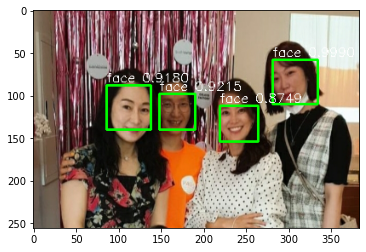

In [608]:
import shutil
import time

import tensorflow as tf
import os, sys

import logging
import argparse
import cv2
import numpy as np

import config 
from make_prior_box import prior_box
from tf_dataloader import load_dataset, _jaccard 
from tf_build_ssd_model import SsdModel

import warnings
warnings.filterwarnings(action='ignore')

# hyperparameters
# args = argparse.ArgumentParser()
# args.add_argument('model_path', type=str, nargs='?', default='checkpoints/')
# args.add_argument('img_path', type=str, nargs='?', default='images/')
# args.add_argument('camera', type=str, nargs='?', default=False)

# args_config = args.parse_args()
# args_config = "images/image.png"

global model
cfg = config.cfg
min_sizes = cfg['min_sizes']
num_cell = [len(min_sizes[k]) for k in range(len(cfg['steps']))]
model_path = os.getenv('HOME')+'/aiffel/face_detector/checkpoints'
img_path = os.getenv('HOME')+'/aiffel/face_detector/image.png'

try:
    model = SsdModel(cfg=cfg, num_cell=num_cell, training=False)

    paths = [os.path.join(model_path, path)
             for path in os.listdir(model_path)]
    latest = sorted(paths, key=os.path.getmtime)[-1]
    model.load_weights(latest)
    print(f"[*] model path : {latest}")

except AttributeError as e:
    print('Please make sure there is at least one weights at {}'.format(model_path))

if not os.path.exists(img_path):
    print(f"Cannot find image path from {img_path}")
    exit()
    
print("[*] Predict {} image.. ".format(img_path))
img_raw = cv2.imread(img_path)
img_raw = cv2.resize(img_raw, (384, 256)) #384, 256
img_height_raw, img_width_raw, _ = img_raw.shape
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# pad input image to avoid unmatched shape problem
img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))
img = img / 255.0 - 0.5

print(f"[*] image.shape:{img.shape}")

priors, _ = prior_box(cfg, image_sizes=(img.shape[0], img.shape[1]))
priors = tf.cast(priors, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

boxes, classes, scores = parse_predict(predictions, priors, cfg)

print(f"[*] scores:{scores}")

# recover padding effect
boxes = recover_pad_output(boxes, pad_params)

print(f"[*] boxes:{boxes}")

# draw and save results
# save_img_path = os.path.join('assets/out_' + img_path)
save_img_path = os.getenv('HOME')+'/aiffel/face_detector/assets/out_image.png'
print(f"[*] save_img_path:{save_img_path}")

for prior_index in range(len(boxes)):
    score = "{:.4f}".format(scores[prior_index])
    class_name = cfg['labels_list']
    show_image(img_raw, boxes, classes, scores, img_height_raw, img_width_raw, prior_index, cfg['labels_list'])

cv2.imwrite(save_img_path, img_raw)
cv2.imshow('results', img_raw)
img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# if cv2.waitKey(0) == ord('q'):
#     exit(0)
if cv2.waitKey(100) and 0xFF == ord('q'):
    exit(0)
cv2.destroyAllWindows()

- 이번 스텝에 소개한 모델 학습 과정을 inference.py에 정리해 두었습니다. 아래와 같이 위의 과정을 실행할 수 있습니다.
(단, 이미지 파일명은 임의로 변경할 수 있습니다. )

- $ cd ~/aiffel/face_detector && python inference.py  checkpoints/image.png 
어떤가요? 결과가 잘 나오시나요? 저는 이렇게 결과가 나왔습니다.

# Step 1. 스티커 구하기 혹은 만들기
- 여러분들은 이미 [카메라 스티커앱 만들기 첫걸음] 노드를 수행해 보셨을 것입니다. 왕관 또는 고양이 수염, 혹은 다양한 아이디어의 스티커를 만들어 볼 수 있을 것입니다. 당시의 스티커 이미지를 그대로 활용하셔도 되고, 다른 이미지를 사용하셔도 무방합니다.


In [609]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

(256, 384, 3) 384 256


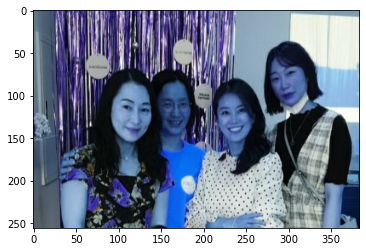

In [610]:
img_path = os.getenv('HOME')+'/aiffel/face_detector/image.png'

img_bgr = cv2.imread(img_path)
img_bgr = cv2.resize(img_bgr, dsize=(384,256)) # 편의를 위해 이미지 크기를 변경합니다. 640x360의 VGA 크기(16:9)로 고정
width = img.shape[1]
height = img.shape[0]
print(img_bgr.shape, width, height)
img_show = img_bgr.copy() # 출력용 이미지 복사
plt.imshow(img_show)

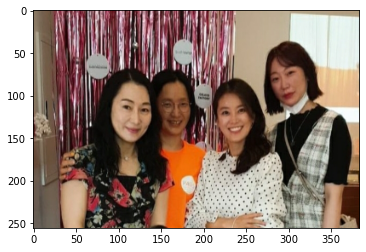

In [611]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# Step 2. SSD 모델을 통해 얼굴 bounding box 찾기
- 우리는 실습코드를 진행하며 필요한 모델을 이미 생성해 왔을 것입니다. 잘 훈련된 해당 모델을 통해 적절한 얼굴 bounding box를 찾아내 봅시다. inference.py 코드를 적극 참고해 보시기를 권합니다.

In [612]:
# dlib을 활용해 hog detector를 선언해 봅시다
import dlib
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)

In [613]:
for i in range(len(boxes)):            # 세로 크기
    l = int(boxes[i][0]*width)
    t = int(boxes[i][1]*height)
    r = int(boxes[i][2]*width)
    b = int(boxes[i][3]*height)
    dlib_rects[i] = dlib.rectangle(l, t, r, b)
    print("SSD 결과:", boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3])
    print("→ 좌표변환 결과:", l, t, r, b)

SSD 결과: 0.7323115 0.22686207 0.87083197 0.43089986
→ 좌표변환 결과: 281 58 334 110
SSD 결과: 0.3858398 0.38434267 0.4958838 0.5503814
→ 좌표변환 결과: 148 98 190 140
SSD 결과: 0.22484455 0.3455399 0.36091587 0.54807496
→ 좌표변환 결과: 86 88 138 140
SSD 결과: 0.5719224 0.43777996 0.68820345 0.6044075
→ 좌표변환 결과: 219 112 264 154


[(281, 58) (334, 110)] 281 58 334 110
[(148, 98) (190, 140)] 148 98 190 140
[(86, 88) (138, 140)] 86 88 138 140
[(219, 112) (264, 154)] 219 112 264 154


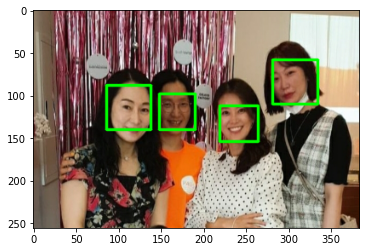

In [614]:
# SSD 결과로 찾은 얼굴 화면에 출력하기

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print(dlib_rect, l, t, r, b)

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()

In [615]:
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

In [616]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

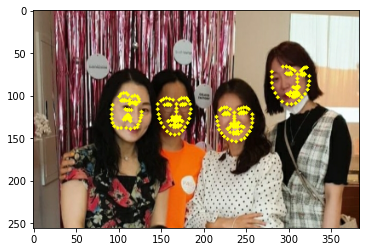

In [617]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [618]:
# 좌표 확인해 보기

x = []
y = []
w = []
h = []
i = 0
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[20]) 
    print (landmark[25]) 
    x.append((landmark[20][0]+landmark[25][0])//2)
    y.append((landmark[20][1]+landmark[25][1])//2 - dlib_rect.width()//2)
    w.append(dlib_rect.width())
    h.append(dlib_rect.height())
    i += 1

(304, 69)
(319, 67)
(160, 104)
(180, 103)
(109, 97)
(124, 104)
(227, 114)
(250, 114)


In [619]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

refined_x = []
refined_y = []
i = 0
for dlib_rect in dlib_rects:
    print ('(x,y) : (%d,%d)'%(x[i], y[i]))
    print ('(w,h) : (%d,%d)'%(w[i], h[i]))
    refined_x.append(x[i] - w[i] // 2)  # left
    refined_y.append(y[i] - h[i]) # top
    print ('(refined_x,refined_y) : (%d,%d)'%(refined_x[i], refined_y[i]))
    i += 1

(x,y) : (311,41)
(w,h) : (54,53)
(refined_x,refined_y) : (284,-12)
(x,y) : (170,82)
(w,h) : (43,43)
(refined_x,refined_y) : (149,39)
(x,y) : (116,74)
(w,h) : (53,53)
(refined_x,refined_y) : (90,21)
(x,y) : (238,91)
(w,h) : (46,43)
(refined_x,refined_y) : (215,48)


In [620]:
# refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x[1], refined_y[1])) # landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

(x,y) : (149,39)
68


# Step 3. dlib 을 이용한 landmark 찾기
- 검출된 bounding box별로 dlib을 이용해 face landmark를 찾을 수 있을 것입니다. inference.py 에서 show_image 메소드를 사용한 부분을 잘 수정하면 가능할 것입니다.

In [621]:
# 원본 이미지에 스티커를 적용합니다. 
img_sticker = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/yellow.png')
sticker_area = []
i = 0
for dlib_rect in dlib_rects:
    img_sticker = cv2.resize(img_sticker, (w[i],h[i]))
    if refined_x[i] < 0 :
        if refined_y[i] < 0 :
            img_sticker = img_sticker[-refined_y[i]:-refined_x[i]]    
            sticker_area.append(img_show[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]])                            
            img_show[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)
        else :
            img_sticker = img_sticker[:-refined_x[i]]
            sticker_area.append(img_show[refined_y[i]:refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]])                            
            img_show[refined_y[i]:refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)

    else :
        if refined_y[i] < 0 :
            img_sticker = img_sticker[-refined_y[i]:]
            sticker_area.append(img_show[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]])                            
            img_show[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)

        else :
            img_sticker = img_sticker[:]
            sticker_area.append(img_show[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]])                            
            img_show[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)
    i += 1

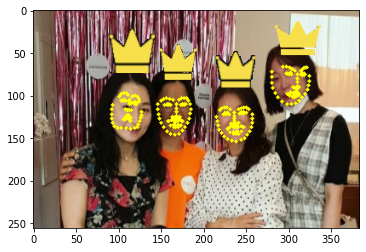

In [622]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# Step 4. 스티커 합성 사진 생성하기
- 여러분들이 선택한 인물사진에 스티커를 합성해 봅시다. 이미지에 너무 많은 사람 얼굴이 포함되어 있거나, 검출된 얼굴이 너무 작아서 스티커 합성이 어울리지 않으면 적당하지 않겠죠? 3~5명 정도의 얼굴이 포함된 적당한 사진을 선택해 주세요.
- 1명의 얼굴에 스티커를 붙여주는 방법은 이미 알고 계실 것입니다. 생성된 이미지를 프로젝트 코드와 함께 제출해 주세요~


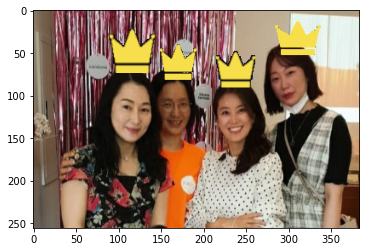

In [623]:
img_sticker = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/yellow.png')
sticker_area = []
i = 0
for dlib_rect in dlib_rects:
    img_sticker = cv2.resize(img_sticker, (w[i],h[i]))
    if refined_x[i] < 0 :
        if refined_y[i] < 0 :
            img_sticker = img_sticker[-refined_y[i]:-refined_x[i]]
            sticker_area.append(img_bgr[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]])                            
            img_bgr[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)
        else :
            img_sticker = img_sticker[:-refined_x[i]]
            sticker_area.append(img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]])                            
            img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)

    else :
        if refined_y[i] < 0 :
            img_sticker = img_sticker[-refined_y[i]:]
            sticker_area.append(img_bgr[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]])                            
            img_bgr[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)

        else :
            img_sticker = img_sticker[:]
            sticker_area.append(img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]])                            
            img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)
    i += 1
    
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# Step 5. dlib을 활용해 hog detector로 동일하게 실행해 보기

(256, 384, 3) 384 256


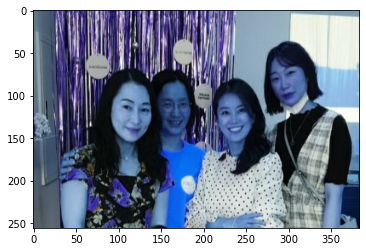

In [624]:
img_path = os.getenv('HOME')+'/aiffel/face_detector/image.png'

img_bgr = cv2.imread(img_path)
img_bgr = cv2.resize(img_bgr, dsize=(384,256)) # 편의를 위해 이미지 크기를 변경합니다. 640x360의 VGA 크기(16:9)로 고정
width = img.shape[1]
height = img.shape[0]
print(img_bgr.shape, width, height)
img_show = img_bgr.copy() # 출력용 이미지 복사
plt.imshow(img_show)

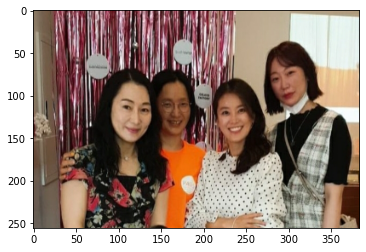

In [625]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [626]:
# dlib을 활용해 hog detector를 선언해 봅시다
import dlib
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

# detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)

[(213, 108) (256, 151)] 213 108 256 151
[(146, 98) (189, 142)] 146 98 189 142
[(95, 95) (147, 147)] 95 95 147 147
[(268, 55) (319, 107)] 268 55 319 107


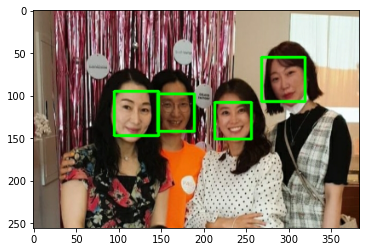

In [627]:
# 찾은 얼굴 화면에 출력하기

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print(dlib_rect, l, t, r, b)

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()

In [628]:
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

In [629]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

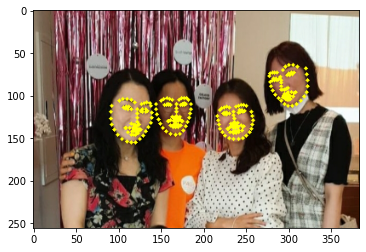

In [630]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [631]:
# 좌표 확인해 보기

x = []
y = []
w = []
h = []
i = 0
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[20]) 
    print (landmark[25]) 
    x.append((landmark[20][0]+landmark[25][0])//2)
    y.append((landmark[20][1]+landmark[25][1])//2 - dlib_rect.width()//2)
    w.append(dlib_rect.width())
    h.append(dlib_rect.height())
    i += 1

(227, 113)
(247, 111)
(160, 104)
(180, 103)
(115, 105)
(137, 109)
(283, 73)
(305, 64)


In [632]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

refined_x = []
refined_y = []
i = 0
for dlib_rect in dlib_rects:
    print ('(x,y) : (%d,%d)'%(x[i], y[i]))
    print ('(w,h) : (%d,%d)'%(w[i], h[i]))
    refined_x.append(x[i] - w[i] // 2)  # left
    refined_y.append(y[i] - h[i]) # top
    print ('(refined_x,refined_y) : (%d,%d)'%(refined_x[i], refined_y[i]))
    i += 1

(x,y) : (237,90)
(w,h) : (44,44)
(refined_x,refined_y) : (215,46)
(x,y) : (170,81)
(w,h) : (44,45)
(refined_x,refined_y) : (148,36)
(x,y) : (126,81)
(w,h) : (53,53)
(refined_x,refined_y) : (100,28)
(x,y) : (294,42)
(w,h) : (52,53)
(refined_x,refined_y) : (268,-11)


In [633]:
# refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x[1], refined_y[1])) # landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

(x,y) : (148,36)
68


In [634]:
# 원본 이미지에 스티커를 적용합니다. 
img_sticker = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/yellow.png')
sticker_area = []
i = 0
for dlib_rect in dlib_rects:
    img_sticker = cv2.resize(img_sticker, (w[i],h[i]))
    if refined_x[i] < 0 :
        if refined_y[i] < 0 :
            img_sticker = img_sticker[-refined_y[i]:-refined_x[i]]    
            sticker_area.append(img_show[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]])                            
            img_show[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)
        else :
            img_sticker = img_sticker[:-refined_x[i]]
            sticker_area.append(img_show[refined_y[i]:refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]])                            
            img_show[refined_y[i]:refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)

    else :
        if refined_y[i] < 0 :
            img_sticker = img_sticker[-refined_y[i]:]
            sticker_area.append(img_show[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]])                            
            img_show[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)

        else :
            img_sticker = img_sticker[:]
            sticker_area.append(img_show[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]])                            
            img_show[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)
    i += 1

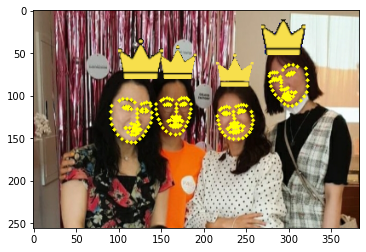

In [635]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

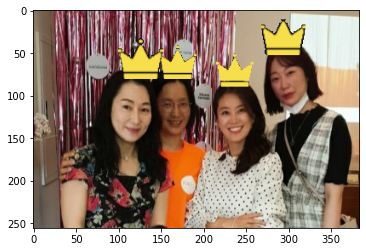

In [636]:
img_sticker = cv2.imread('/home/aiffel0042/aiffel/camera_sticker/images/yellow.png')
sticker_area = []
i = 0
for dlib_rect in dlib_rects:
    img_sticker = cv2.resize(img_sticker, (w[i],h[i]))
    if refined_x[i] < 0 :
        if refined_y[i] < 0 :
            img_sticker = img_sticker[-refined_y[i]:-refined_x[i]]
            sticker_area.append(img_bgr[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]])                            
            img_bgr[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)
        else :
            img_sticker = img_sticker[:-refined_x[i]]
            sticker_area.append(img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]])                            
            img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], -refined_x[i]:-refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)

    else :
        if refined_y[i] < 0 :
            img_sticker = img_sticker[-refined_y[i]:]
            sticker_area.append(img_bgr[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]])                            
            img_bgr[-refined_y[i]:-refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)

        else :
            img_sticker = img_sticker[:]
            sticker_area.append(img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]])                            
            img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = \
                np.where(img_sticker==0,sticker_area[i],img_sticker).astype(np.uint8)
    i += 1
    
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 루브릭

## 프로젝트 평가 기준

평가문항	상세기준
1. multiface detection을 위한 widerface 데이터셋의 전처리가 적절히 진행되었다.
    - tfrecord 생성, augmentation, prior box 생성 등의 과정이 정상적으로 진행되었다.
2. SSD 모델이 안정적으로 학습되어 multiface detection이 가능해졌다.
    - inference를 통해 정확한 위치의 face bounding box를 detect한 결과이미지가 제출되었다.
3. 이미지 속 다수의 얼굴에 스티커가 적용되었다.
    - 이미지 속 다수의 얼굴의 적절한 위치에 스티커가 적용된 결과이미지가 제출되었다.


# ★ 프로젝트 결과 ★

## 1. 데이터셋 전처리 과정 완료

- tfrecord 생성, augmentation, prior box 생성 등

- 원본 이미지 (256, 384, 3)

![title](./images/image.png)


## 2. SSD 모델의 안정적 학습: 200 epochs

- multiface detection 결과 이미지

![title](./images/SSD_Detector1.png)
![title](./images/SSD_Detector2.png)
![title](./images/SSD_Detector3.png)

## 3. 이미지 속 다수의 얼굴에 스티커 적용

- multiface detection 및 스티커 적용 결과 이미지

![title](./images/SSD_Detector4.png)
![title](./images/SSD_Detector5.png)

## 4. dlib을 활용해 hog detector로 동일하게 실행해 보기

- SSD 모델보다는 dlib에서 제공되는 hog detector 결과가 더 좋은 것 같다. 

![title](./images/Hog_Detector1.png)
![title](./images/Hog_Detector2.png)
![title](./images/Hog_Detector3.png)
![title](./images/Hog_Detector4.png)


In [ ]:
- 